In [1]:
import torch
import torch.nn
import torch.utils
import torch.utils.data
import torch.nn.functional as F
import fine_tune
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
TASK = 'qnli'
TEACHER_EXP = 'teacher_base'
TMODEL = 'bert'
TCKPT = 8000
STUDENT_EXP = 'MSE_init_from_pre_trained'
SMODEL = 'bert'
SCKPT = 12000
DATASET = 'dev'
SDEVICE = 0
TDEVICE = 0
BATCH_SIZE = 1

In [3]:
teacher_config = fine_tune.config.TeacherConfig.load(
    experiment=TEACHER_EXP,
    model=TMODEL,
    task=TASK
)
teacher_config.device_id = TDEVICE
teacher_config.dataset = DATASET
print(teacher_config)


+---------------------------------------+
| configuration     | value             |
+---------------------------------------+
| accum_step        | 2                 |
| amp               | 0                 |
| batch_size        | 32                |
| beta1             | 0.9               |
| beta2             | 0.999             |
| ckpt_step         | 1000              |
| dataset           | dev               |
| device_id         | 0                 |
| dropout           | 0.1               |
| eps               | 1e-08             |
| experiment        | teacher_base      |
| log_step          | 500               |
| lr                | 3e-05             |
| max_norm          | 1.0               |
| max_seq_len       | 128               |
| model             | bert              |
| num_class         | 2                 |
| ptrain_ver        | bert-base-uncased |
| seed              | 42                |
| task              | qnli              |
| total_step        | 9822       

In [4]:
fine_tune.util.set_seed_by_config(teacher_config)

In [5]:
student_config = fine_tune.config.StudentConfig.load(
    experiment=STUDENT_EXP,
    model=SMODEL,
    task=TASK
)
student_config.device_id = SDEVICE
student_config.dataset = DATASET
print(student_config)


+-------------------------------------------------------+
| configuration             | value                     |
+-------------------------------------------------------+
| accum_step                | 1                         |
| amp                       | 0                         |
| batch_size                | 32                        |
| beta1                     | 0.9                       |
| beta2                     | 0.999                     |
| ckpt_step                 | 1000                      |
| d_emb                     | 128                       |
| d_ff                      | 3072                      |
| d_model                   | 768                       |
| dataset                   | dev                       |
| device_id                 | 0                         |
| dropout                   | 0.1                       |
| eps                       | 1e-08                     |
| experiment                | MSE_init_from_pre_trained |
| log_step   

In [6]:
dataset = fine_tune.util.load_dataset_by_config(
    config=teacher_config
)

2021/05/10 12:36:45 - INFO - fine_tune.task -   Start loading task QNLI dataset dev.
Loading QNLI dev: 5463it [00:00, 347790.52it/s]
2021/05/10 12:36:45 - INFO - fine_tune.task -   Number of samples: 5463
2021/05/10 12:36:45 - INFO - fine_tune.task -   Finish loading task QNLI dataset dev.


In [7]:
teacher_tknr = fine_tune.util.load_teacher_tokenizer_by_config(
    config=teacher_config
)
student_tknr = fine_tune.util.load_student_tokenizer_by_config(
    config=student_config
)

In [8]:
TEACHER_EXP_NAME = fine_tune.config.BaseConfig.experiment_name(
    experiment=teacher_config.experiment,
    model=teacher_config.model,
    task=teacher_config.task
)
TEACHER_EXP_DIR = os.path.join(
    fine_tune.path.FINE_TUNE_EXPERIMENT,
    TEACHER_EXP_NAME
)
print(TEACHER_EXP_DIR)

/home/kychen/Desktop/BERT-gang/data/fine_tune_experiment/teacher_base_bert_qnli


In [9]:
teacher_model = fine_tune.util.load_teacher_model_by_config(
    config=teacher_config
)
teacher_model.load_state_dict(
    torch.load(
        os.path.join(TEACHER_EXP_DIR, f'model-{TCKPT}.pt'),
        map_location=teacher_config.device
    )
)

<All keys matched successfully>

In [10]:
STUDENT_EXP_NAME = fine_tune.config.BaseConfig.experiment_name(
    experiment=student_config.experiment,
    model=student_config.model,
    task=student_config.task
)
STUDENT_EXP_DIR = os.path.join(
    fine_tune.path.FINE_TUNE_EXPERIMENT,
    STUDENT_EXP_NAME
)
print(STUDENT_EXP_DIR)

/home/kychen/Desktop/BERT-gang/data/fine_tune_experiment/MSE_init_from_pre_trained_bert_qnli


In [11]:
student_model = fine_tune.util.load_student_model_by_config(
    config=student_config,
    tokenizer=student_tknr
)
student_model.load_state_dict(
    torch.load(
        os.path.join(STUDENT_EXP_DIR, f'model-{SCKPT}.pt'),
        map_location=student_config.device
    )
)

2021/05/10 12:36:56 - INFO - fine_tune.model.student_bert -   Load model state dict from pre-trained model
2021/05/10 12:36:56 - INFO - fine_tune.model.student_bert -   Finish initialization from pre-trained model


<All keys matched successfully>

In [12]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    collate_fn=dataset.create_collate_fn(),
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [13]:
cosine_sim = torch.nn.CosineSimilarity()

y_ground = []
y_teacher = []
y_student = []
correct_sim = []
false_sim = []
false_pos_sim = []
false_neg_sim = []

In [14]:
student_model.eval()
teacher_model.eval()


with torch.no_grad():
    for text, text_pair, label in tqdm(dataloader):
        teacher_encode = teacher_tknr(
            text=text,
            text_pair=text_pair,
            padding='max_length',
            max_length=teacher_config.max_seq_len,
            return_tensors='pt',
            truncation=True
        )
        teacher_input_ids = teacher_encode['input_ids']
        teacher_token_type_ids = teacher_encode['token_type_ids']
        teacher_attention_mask = teacher_encode['attention_mask']

        student_encode = student_tknr(
            text=text,
            text_pair=text_pair,
            padding='max_length',
            max_length=student_config.max_seq_len,
            return_tensors='pt',
            truncation=True
        )
        student_input_ids = student_encode['input_ids']
        student_token_type_ids = student_encode['token_type_ids']
        student_attention_mask = student_encode['attention_mask']

        t_logits, t_cls = teacher_model(
            input_ids = teacher_input_ids.to(teacher_config.device),
            token_type_ids = teacher_token_type_ids.to(teacher_config.device),
            attention_mask = teacher_attention_mask.to(teacher_config.device)
        )

        s_logits, s_cls = student_model(
            input_ids = student_input_ids.to(student_config.device),
            token_type_ids = student_token_type_ids.to(student_config.device),
            attention_mask = student_attention_mask.to(student_config.device)
        )

        gt = label[-1]
        t_pred_label = F.softmax(t_logits, dim=-1).argmax(dim=-1).to('cpu').detach().item()
        s_pred_label = F.softmax(s_logits, dim=-1).argmax(dim=-1).to('cpu').detach().item()


        y_ground.append(gt)
        y_teacher.append(t_pred_label)
        y_student.append(s_pred_label)

        if gt == t_pred_label and gt == s_pred_label:
            correct_sim.append(cosine_sim(s_cls, t_cls).to('cpu').detach().item())
        elif gt == t_pred_label and gt != s_pred_label:
            false_pos_sim.append(cosine_sim(s_cls, t_cls).to('cpu').detach().item())
        elif gt != t_pred_label and gt == s_pred_label:
            false_neg_sim.append(cosine_sim(s_cls, t_cls).to('cpu').detach().item())
        else:
            false_sim.append(cosine_sim(s_cls, t_cls).to('cpu').detach().item())

    


100%|██████████| 5463/5463 [01:00<00:00, 89.68it/s]


## Confusion matrix of teacher and student outputs

In [15]:
cm = confusion_matrix(y_teacher, y_student)

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

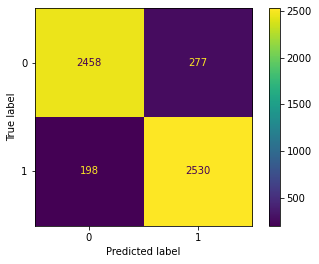

In [17]:
disp.plot(values_format='d')

## Confusion matrix of teacher and ground truth

In [18]:
cm2 = confusion_matrix(y_ground, y_teacher)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)

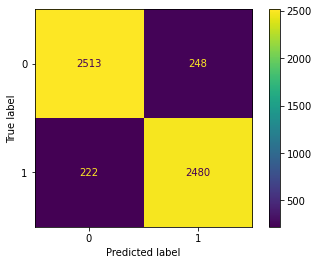

In [19]:
disp2.plot(values_format='d')

## Confusion matrix of student and ground truth

In [20]:
cm3 = confusion_matrix(y_ground, y_student)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3)

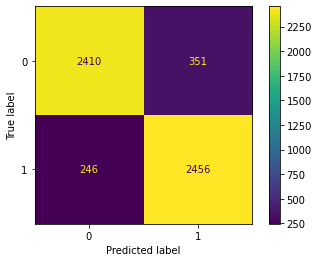

In [21]:
disp3.plot(values_format='d')

In [22]:
print(y_ground.count(0))
print(y_teacher.count(0))
print(y_student.count(0))

2761
2735
2656


In [23]:
print(y_ground.count(1))
print(y_teacher.count(1))
print(y_student.count(1))

2702
2728
2807


In [24]:
t_acc = accuracy_score(y_ground, y_teacher)
print(t_acc)

0.9139666849716274


In [25]:
s_acc = accuracy_score(y_ground, y_student)
print(s_acc)

0.8907193849533224


In [26]:
len(dataset) * (t_acc - s_acc)

127.00000000000018

In [27]:
y_teacher = np.asarray(y_teacher)
y_ground = np.asarray(y_ground)
y_student = np.asarray(y_student)

In [28]:
correct_sim = np.asarray(correct_sim)
print(correct_sim.size)
false_sim = np.asarray(false_sim)
print(false_sim.size)
false_pos_sim = np.asarray(false_pos_sim)
false_neg_sim = np.asarray(false_neg_sim)
print(false_pos_sim.size)
print(false_neg_sim.size)

4692
296
301
174


In [29]:
print(correct_sim[correct_sim > 0.5])
print(correct_sim[correct_sim > 0.5].size)

[0.51427412 0.66697979 0.63431376 0.69082052 0.78085518 0.54530066
 0.56180429 0.65013158 0.60513848 0.50981307 0.56303406 0.50705463
 0.54958135 0.64722687 0.64026743 0.58129996 0.6018312  0.51463354
 0.63183767 0.70313573 0.58732492 0.51621437 0.54561293 0.55151027
 0.79060769 0.52433103 0.69966424 0.61378634 0.59610736 0.58109421
 0.50532115 0.64593393 0.50870579 0.52018285 0.63751769 0.53397334
 0.67012727 0.52171648 0.58940512 0.53787035 0.65179187 0.68858093
 0.67467207 0.72675383 0.5059132  0.60637635 0.50129873 0.806647
 0.64448261 0.60214114 0.51041746 0.54023486 0.5693804  0.72030491
 0.60920763 0.51564437 0.56349689 0.58838004 0.5105471  0.56385177
 0.66950542 0.58119607 0.61841011 0.51810968 0.62002748 0.70948505
 0.57132971 0.57152939 0.71149814 0.72394174 0.6666733  0.57891941
 0.50280023 0.6365642  0.61916196 0.53190166 0.5275225  0.66625762
 0.56334865 0.50044453 0.67139554 0.54429168 0.50910616 0.59334749
 0.56045437 0.51897395 0.68028545 0.7397939  0.67624056 0.647701

In [30]:
print(correct_sim[correct_sim < 0.5])
print(correct_sim[correct_sim < 0.5].size)

[ 0.3354643  -0.02618467  0.29613334 ... -0.2066309   0.07241996
 -0.10376381]
4159


In [31]:
print(false_sim[false_sim > 0.5])
print(false_sim[false_sim > 0.5].size)

[0.51422983 0.59176582 0.67929268 0.64348525 0.57166749 0.52475286
 0.56744587 0.51451743 0.7463854  0.63917726 0.52822584 0.71526384
 0.67410606 0.51352942 0.53364938 0.53303403 0.6244421  0.51579577
 0.54085475 0.5846172  0.65035874 0.51537019 0.54100466 0.50830638
 0.77713603 0.52750701 0.73914164 0.58405757 0.67340314 0.66197634
 0.5599339  0.54397321 0.78117388 0.69594884 0.52772605 0.7779398
 0.65715009 0.56084472 0.53025001 0.59841257 0.65028965 0.51168567
 0.64184254 0.56165981 0.66001344 0.60833246 0.58783281 0.62829226
 0.5194118  0.63899392 0.59066755 0.58639574 0.72470087 0.53541875
 0.59188771 0.60101408 0.64480823 0.61688411 0.81162429 0.51999021
 0.65943944 0.50972623 0.75733894 0.74647051 0.77288663 0.629197
 0.68797755 0.61163968 0.54731065 0.63064563 0.69789225 0.50885934
 0.51234746 0.64405215 0.5405274  0.53818464 0.73324698 0.51836866
 0.58654189 0.69735026 0.69743925 0.51342839 0.54830247 0.74507582
 0.60405916 0.61900711 0.58296698 0.69321102 0.59809971 0.535689


In [32]:
print(false_sim[false_sim < 0.5])
print(false_sim[false_sim < 0.5].size)

[ 0.26163039  0.2756058   0.42665541  0.24172844  0.29390168  0.48361674
  0.39906642  0.48658895  0.48961622  0.35005975  0.34628245 -0.20728664
 -0.42364037  0.473306   -0.04701476  0.45865962  0.4110764   0.47275621
  0.15229239 -0.06801116 -0.14835471  0.33558601  0.35688436  0.33414644
 -0.09399346  0.47527671  0.40367886 -0.22627157  0.13997406  0.45460176
  0.42818415 -0.17868268 -0.0250665   0.4740454   0.02327762  0.39045194
  0.30426723  0.40781447  0.41389364 -0.05343802  0.34349948  0.311221
  0.48345381 -0.01012834  0.29725838 -0.1712216   0.30677179  0.15435994
  0.36294255  0.46828446  0.29971698  0.38866362  0.33794251  0.44546047
  0.48834947  0.32932568  0.37400523 -0.1057537   0.48322222  0.45207962
 -0.08994093  0.44950959  0.21302104  0.49575931  0.47506469  0.41158229
  0.48442227  0.05886311  0.4855243   0.29897383  0.11364764  0.18552437
  0.15091956  0.33836398  0.43312752  0.44583866  0.39165443 -0.23246662
  0.42272553  0.48993152 -0.06887185  0.32371274  0.2

In [33]:
print(false_neg_sim[false_neg_sim > 0.5])
print(false_neg_sim[false_neg_sim > 0.5].size)

[0.53776532 0.54220951 0.51815104 0.63478422 0.72447932 0.51188827
 0.61098087 0.73749095 0.76551938 0.62799531 0.56387442 0.62121552
 0.60966545 0.56683898 0.55968267 0.66519058 0.67677957 0.63115245
 0.70680135 0.61224461 0.69023073 0.54413772 0.51607096 0.69586086
 0.51056176 0.64000207 0.55501032 0.61309433 0.56389505 0.60316843
 0.60892653 0.54192054 0.59576041 0.73400021 0.59084731 0.51564747
 0.53469193 0.50570196 0.52362758 0.51511329 0.6821419  0.55629832
 0.7094928  0.66485667 0.7128582  0.64287949 0.51608139 0.60118634
 0.5862906  0.58519661 0.5475812  0.59361559 0.52836561 0.66715521
 0.63700521 0.52320349]
56


In [34]:
print(false_neg_sim[false_neg_sim < 0.5])
print(false_neg_sim[false_neg_sim < 0.5].size)

[ 0.18413536  0.45937902  0.31511876  0.07173815  0.25003105  0.30730745
  0.48038962  0.4089866  -0.03799752  0.40480131  0.42254069  0.37721682
  0.17291401  0.31347698  0.40207621  0.44448945  0.34610704  0.33676335
  0.36637887  0.05728206  0.15742433  0.39129466  0.34922147  0.02795126
  0.33040494  0.36952636  0.07774484  0.17640725  0.32365337  0.45992407
  0.45605126  0.29253027  0.45890364  0.32625341  0.2676549   0.30375126
 -0.14037611  0.19500452  0.38615543  0.26681229  0.40944049  0.08255798
  0.18950252  0.26556057  0.41021803  0.27239338  0.27743849  0.06009588
  0.33960992  0.25943318  0.36301827  0.48566893  0.35687819  0.10130645
  0.48469558  0.15251203  0.29048723  0.35066578  0.37489352  0.35786062
  0.04964609  0.48937485  0.18203989 -0.13136667  0.22277157 -0.0364795
  0.34109011  0.48784614  0.2554642  -0.30342916  0.30738482  0.05571554
 -0.10007593  0.09232267  0.48336726  0.11115368  0.42576855  0.35152248
  0.17221817  0.19556792  0.18094744  0.44534406  0.

In [35]:
print(false_pos_sim[false_pos_sim > 0.5])
print(false_pos_sim[false_pos_sim > 0.5].size)

[0.53005469 0.66138953 0.61441255 0.5446524  0.63842249 0.5587371
 0.62817258 0.72693056 0.60575217 0.65147549 0.52649736 0.76108891
 0.52442968 0.6723612  0.70337307 0.56727004 0.50362825 0.52743429
 0.6238423  0.51019371 0.58907777 0.62267691 0.72222728 0.66344506
 0.64748383 0.50066227 0.52563876 0.70885384 0.51635009 0.56971371
 0.6462447  0.54614109 0.51702499 0.51725203 0.5177542  0.51204884
 0.66104311 0.56399292 0.68084013 0.67879307 0.59078914 0.62075925
 0.55511743 0.67735034 0.60688174 0.70407665 0.56163782 0.73406607
 0.67884427 0.64287668 0.54312623 0.64540052 0.61629385 0.5248996
 0.6084789  0.6830042  0.60462886 0.50487447 0.74807245 0.66230017
 0.64039344 0.6495977  0.57242686 0.52657056 0.68215752 0.52259904
 0.68791121 0.76195592 0.73925418 0.63914531 0.57219511 0.58464891
 0.68508863 0.53067511]
74


In [36]:
print(false_pos_sim[false_pos_sim < 0.5])
print(false_pos_sim[false_pos_sim < 0.5].size)

[-0.39413849  0.36518139 -0.09624619  0.40614578 -0.13965911  0.10174747
  0.24097438  0.42839786  0.47021455  0.20606062  0.30496776  0.49164268
 -0.0545568   0.26349723 -0.13966696 -0.39839506 -0.03915063  0.34941393
  0.44360614  0.19628359  0.23990636 -0.32520565  0.21153609 -0.29510272
 -0.08639222  0.30311215  0.1182356   0.29014686  0.3067635  -0.22337562
  0.15155239  0.08433066  0.35583365  0.4203091   0.39996386  0.07037513
  0.37999365 -0.0585269   0.11405785  0.37426007  0.47581872  0.28075957
  0.19266772  0.42732438  0.15715039  0.2079054  -0.06651785  0.16521408
 -0.18494494  0.37858272  0.39671731  0.35207859 -0.40237045  0.440162
  0.29461724  0.46389335  0.43097758  0.11285099  0.33097127  0.2192664
  0.087745    0.33263433 -0.09657611 -0.22996157  0.14778306 -0.06460381
 -0.09496243  0.41325426  0.23791477 -0.31544384  0.16036054  0.34300196
  0.17171629 -0.03674468  0.38636714  0.29294297  0.2188196   0.34337145
 -0.06698506  0.01360378  0.1466503   0.30315503  0.00